# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
from prettytable import PrettyTable
import gc
import copy
import time

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
start_time = time.time()
training_data = pd.read_csv("data_topic/train.csv")
development_data = pd.read_csv("data_topic/dev.csv")
test_data = pd.read_csv("data_topic/test.csv")

In [3]:
train_content = training_data.iloc[:,1].to_list()
development_content = development_data.iloc[:,1].to_list()
test_content = test_data.iloc[:,1].to_list()
train_label = training_data.iloc[:,0].to_numpy()
development_label = development_data.iloc[:,0].to_numpy()
test_label = test_data.iloc[:,0].to_numpy()

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
   
    tokenRE = re.compile(token_pattern)
   
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
   
    # this is to store the ngrams to be returned
    x = []
   
    if ngram_range[0]==1:
        x = x_uni
   
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
       
        # ignore unigrams
        if n==1: continue
       
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1].
        # Note that x_uni and x_uni[1:] have different lengths
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
       
    for n in ngrams:
        for t in n:
            x.append(t)
       
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, stop_words=[]):
   
   
    tokenRE = re.compile(token_pattern)
   
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
   
    # iterate through each raw text
    for x in X_raw:
       
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
       
        #update doc and ngram frequencies
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set.
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
   
    # keep elements with doc frequency > minimum term freq (keep_topN)
    # if use keep_topN as the most frequent N words to keep,
    # you don't know which word to choose if N and N+1 words have the same frequency.
    # so I choose to keep words which appear more than N times.
    if keep_topN>0:
        vocab = set([w for w in ngram_counts if ngram_counts[w]>=keep_topN])
   
   
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, tf = get_vocab(X_raw=train_content, min_df=0, keep_topN=0, stop_words=stop_words)

In [8]:
# fix the order in the vocab by sorting the list using first element in the tuple
vocab_list = sorted(vocab, key=lambda tup: str(tup))

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [9]:
vocab_to_id = {}
id_to_vocab = {}
i = 0
for word in vocab:
    vocab_to_id[word]=i
    id_to_vocab[i] = word
    i += 1

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [10]:
processed_train=[]
processed_development=[]
processed_test=[]
# represent documents in train, dev and test sets as lists of words in the vocabulary
for i in range(len(train_content)):
    processed_train.append(extract_ngrams(x_raw=train_content[i], ngram_range=(1,1),
                                          stop_words=stop_words, vocab=vocab))
for i in range(len(development_content)):
    processed_development.append(extract_ngrams(x_raw=development_content[i], ngram_range=(1,1),
                                                stop_words=stop_words, vocab=vocab))
for i in range(len(test_content)):
    processed_test.append(extract_ngrams(x_raw=test_content[i], ngram_range=(1,1),
                                         stop_words=stop_words, vocab=vocab))

Then convert them into lists of indices in the vocabulary:

In [11]:
# Here I use deepcopy because I may use the processed train later
train_indices = copy.deepcopy(processed_train)
development_indices = copy.deepcopy(processed_development)
test_indices = copy.deepcopy(processed_test)
for i in range(len(train_indices)):
    for j in range(len(train_indices[i])):
        train_indices[i][j] = vocab_to_id[train_indices[i][j]]
for i in range(len(development_indices)):
    for j in range(len(development_indices[i])):
        development_indices[i][j] = vocab_to_id[development_indices[i][j]]
for i in range(len(test_indices)):
    for j in range(len(test_indices[i])):
        test_indices[i][j] = vocab_to_id[test_indices[i][j]]

Put the labels `Y` for train, dev and test sets into arrays: 

In [12]:
# change the labels from [1,2,3] to [0,1,2]
train_label = train_label-1
development_label = development_label-1
test_label = test_label-1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [13]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W = dict()
    W[0] = np.random.uniform(-init_val, init_val, (vocab_size, embedding_dim))
    for i in range(1, len(hidden_dim)+1):
        if i == 1:
            W[i] = np.random.uniform(-init_val, init_val, (embedding_dim, hidden_dim[i-1]))
        else:
            W[i] = np.random.uniform(-init_val, init_val, (hidden_dim[i-2], hidden_dim[i-1]))
            
    # get the W between y and the last hidden layer
    if len(hidden_dim)>0:
        W[len(hidden_dim)+1] = np.random.uniform(-init_val, init_val, (hidden_dim[len(hidden_dim)-1], num_classes))
    # if there is no hidden layer, W[1] is the weight between embedding layer and y
    else:
        W[1] = np.random.uniform(-init_val, init_val, (embedding_dim, num_classes))
    return W 

# Embedding layer = X * W[0]
# hidden layer 1 = embedding layer * W[1]
# hidden layer 2 = hidden layer 1 * W[2]
# ......
# num_classes = hidden layer n * W[n+1]

In [14]:
np.random.seed(123)
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [15]:
def softmax(z):
    sig = np.exp(z)/sum(np.exp(z))

    return sig

# exp() all elements in z and divided by the sum of exp(z)

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [16]:
def categorical_loss(y, y_preds):
    l = -y * np.log(max(y_preds))
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [17]:
def relu(z):
    z_copy = z.copy()
    # return 0 if the value of z is less than 0
    a = np.maximum(z_copy, 0)
    return a
    
def relu_derivative(z):
    z_copy = z.copy()
    dz = np.empty(len(z_copy))
    for i in range(len(z_copy)):
        if z_copy[i] > 0:
            dz[i] = 1
        else:
            dz[i] = 0    
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [18]:
def dropout_mask(size, dropout_rate):
    dropout_vec = np.ones(size)
    indices = np.random.choice(np.arange(size), replace=False, size=int(size * dropout_rate))
    dropout_vec[indices] = 0    
    return dropout_vec    

In [19]:
np.random.seed(123)
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[1. 1. 1. 0. 1. 0. 1. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [20]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    # first, compute for the embedding layer
    vec = [W[0][indices] for indices in x]
    embedding_layer = np.sum(vec,axis = 0)/len(x)
    h_vecs.append(embedding_layer)
    a0 = relu(embedding_layer)
    a_vecs.append(a0)
    dropout_vec0 = dropout_mask(len(a0), dropout_rate)
    dropout_vecs.append(dropout_vec0)
    after_dropout = embedding_layer*dropout_vec0

    # then, compute the other hidden layers
    for i in range(1,len(W)-1):
        h = np.dot(after_dropout, W[i])
        a = relu(h)
        dropout_vec = dropout_mask(len(a), dropout_rate)
        after_dropout = a*dropout_vec
        
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(dropout_vec)

    # compute the prediction
    prediction = softmax(np.dot(after_dropout,W[len(W)-1]))
    # set the out_vals
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout vecs'] = dropout_vecs
    out_vals['prediction'] = prediction   
    
    return out_vals    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [21]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    # first compute the W between output and last hidden layer
    # Use the last W to set the length of array of labels
    true_labels = np.zeros(W[len(W)-1].shape[1])
    # set the true category to 1
    true_labels[y] = 1
    # compute the difference between true labels and prediction
    gradient = (out_vals['prediction'] - true_labels).reshape(1, -1) # (n, ) reshape to (1,n)
    last_layer = (out_vals['a'][-1]*out_vals['dropout vecs'][-1]).reshape(-1, 1) # (m, ) reshape to (m,1)
    dw = np.dot(last_layer, gradient) # mxn
    # change w
    W[len(W)-1] = W[len(W)-1] - lr*dw # mxn
    gradient = (np.dot(W[len(W)-1],gradient.T)) * out_vals['dropout vecs'][len(W)-2].reshape(-1,1) #(m,1)
    
    for i in range(1, len(W)-1):
        gradient = gradient * relu_derivative(out_vals['h'][len(W)-i-1]).reshape(-1,1) # (m,1)
        last_layer = (out_vals['a'][len(W)-i-2]*out_vals['dropout vecs'][len(W)-i-2]).reshape(-1,1) # (n,)
        dw = np.dot(last_layer, gradient.T)
        # change w
        W[len(W)-i-1] = W[len(W)-i-1] - lr*dw
        gradient = np.dot(W[len(W)-i-1], gradient) * out_vals['dropout vecs'][len(W)-i-2].reshape(-1,1)
        
    # decide whether to change W[0] or not    
    if freeze_emb == False:
        gradient = gradient * relu_derivative(out_vals['h'][0]).reshape(-1,1)
        W[0][x] = W[0][x] - lr*(gradient.reshape(-1,))
    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [22]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    training_loss_history = []
    validation_loss_history = []
    index = np.arange(len(X_tr))
    for i in range(epochs):
        random.Random(32*i).shuffle(index)
        
        for indices in index:
            out_vals = forward_pass(x=X_tr[indices], W=W, dropout_rate=dropout)
            # update w
            W = backward_pass(x=X_tr[indices], y=Y_tr[indices], W=W, out_vals=out_vals, lr=lr, freeze_emb=freeze_emb)

        training_loss = 0    
        for j in range(len(X_tr)):    
            y_pred_train = forward_pass(x=X_tr[j], W=W, dropout_rate=dropout)['prediction']
            training_loss = categorical_loss(Y_tr[j], y_pred_train) + training_loss   
        training_loss_history.append(training_loss/len(X_tr))
        
        validation_loss = 0    
        for k in range(len(X_dev)):    
            y_pred_dev = forward_pass(x=X_dev[k], W=W, dropout_rate=dropout)['prediction']
            validation_loss = categorical_loss(Y_dev[k], y_pred_dev) + validation_loss   
        validation_loss_history.append(validation_loss/len(X_dev))
        
        if i>0:
            if abs(validation_loss_history[i-1]-validation_loss_history[i])<tolerance:
                break
    if print_progress==True:
        print('train loss: ', training_loss_history)
        print('------------------------------------------------')
        print('val loss: ', validation_loss_history)   
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [23]:
W = network_weights(vocab_size=len(vocab),embedding_dim=50,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (81707, 50)
Shape W1 (50, 3)


### Discuss how did you choose model hyperparameters ? 

max accuracy: 0.9060402684563759
lr:  0.001
dropout:  0.1
hidden_dim:  300
+-------------------+--------------------+--------------------+--------------------+
|     lr = 0.01     |   dropout = 0.1    |   dropout = 0.2    |   dropout = 0.3    |
+-------------------+--------------------+--------------------+--------------------+
|  embedding_dim=50 |  0.87248322147651  | 0.8590604026845637 | 0.8657718120805369 |
| embedding_dim=200 | 0.8389261744966443 | 0.8590604026845637 | 0.8590604026845637 |
| embedding_dim=300 | 0.8657718120805369 |  0.87248322147651  | 0.8791946308724832 |
+-------------------+--------------------+--------------------+--------------------+
+-------------------+--------------------+--------------------+--------------------+
|     lr = 0.001    |   dropout = 0.1    |   dropout = 0.2    |   dropout = 0.3    |
+-------------------+--------------------+--------------------+--------------------+
|  embedding_dim=50 | 0.8993288590604027 | 0.9060402684563759 | 0.892617449

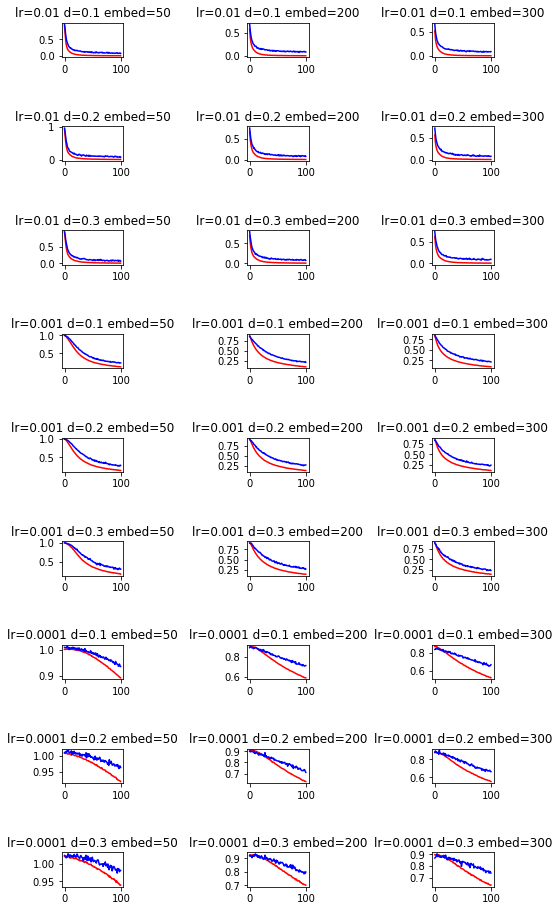

In [24]:
tune1_start = time.time()
np.random.seed(123)
lr = [0.01, 0.001, 0.0001]
dropout = [0.1, 0.2, 0.3]
embedding_dim = [50, 200, 300]
# create the table showing performance of each model. Here I use accuracy as the performance.
table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
acc_history = []

z=1

for i in range(len(lr)):
    for j in range(len(dropout)):
        for k in range(len(embedding_dim)):            
            # train model with different parameters
            W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim[k],
                    hidden_dim=[], num_classes=3)

            W, loss_tr, dev_loss = SGD(train_indices, train_label,
                                        W,
                                        X_dev=development_indices, 
                                        Y_dev=development_label,
                                        lr=lr[i], 
                                        dropout=dropout[j],
                                        freeze_emb=False,
                                        tolerance=0.0000001,
                                        epochs=100, print_progress=False)
            # choose the best model by selecting the highest accuracy on the dev set
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(development_indices,development_label)]
            acc_history.append(accuracy_score(development_label,preds_te))
            plt.subplot(9,3,z)
            plt.plot(loss_tr, 'r')
            plt.plot(dev_loss, 'b')
            plt.title('lr={}'.format(lr[i])+' d={}'.format(dropout[j])+' embed={}'.format(embedding_dim[k]))
            
            z+=1
            
    if i == 0:
        table_lr0.add_row(["embedding_dim={}".format(embedding_dim[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr0.add_row(["embedding_dim={}".format(embedding_dim[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr0.add_row(["embedding_dim={}".format(embedding_dim[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])
    if i == 1:
        table_lr1.add_row(["embedding_dim={}".format(embedding_dim[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr1.add_row(["embedding_dim={}".format(embedding_dim[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr1.add_row(["embedding_dim={}".format(embedding_dim[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])
    if i == 2:
        table_lr2.add_row(["embedding_dim={}".format(embedding_dim[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr2.add_row(["embedding_dim={}".format(embedding_dim[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr2.add_row(["embedding_dim={}".format(embedding_dim[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])

result = max(acc_history)
print('max accuracy:', result)
index_of_result = acc_history.index(result)
lr_index = (index_of_result)//9
dropout_index = (index_of_result%9)//3
embedding_dim_index = (index_of_result%3)
print('lr: ', lr[lr_index])
print('dropout: ', dropout[dropout_index])
print('hidden_dim: ', embedding_dim[embedding_dim_index])
print(table_lr0)
print(table_lr1)
print(table_lr2)
plt.subplots_adjust(left=6,
                    bottom=2, 
                    right=7, 
                    top=5, 
                    wspace=2, 
                    hspace=2)
plt.show()
tune1_end = time.time()

train loss:  [0.8705810098948751, 0.8271895816214632, 0.7722783521071748, 0.7236147657802364, 0.6824851644597026, 0.6434249754677906, 0.6083545182403972, 0.5774784748784694, 0.5537209926764114, 0.5308039801842164, 0.5041881702796684, 0.4847065461198263, 0.4671840774007567, 0.45021195955393023, 0.43475962369012927, 0.41868003439402046, 0.4042704566783646, 0.39388749166625125, 0.38133899373659713, 0.37072106944896277, 0.3564572640189147, 0.35086101941358344, 0.3393565556084791, 0.3301369587206135, 0.32181065129249237, 0.3124111968751242, 0.30542971594566776, 0.3004255983766745, 0.29083486367364747, 0.2837779691243959, 0.2780983673956035, 0.2708029428421169, 0.26402163108632465, 0.2584520084319976, 0.2551847092127683, 0.2500122805841183, 0.24225529221683564, 0.23947477753471114, 0.23576933693892296, 0.22869068189399966, 0.22624410375867685, 0.22053545004957933, 0.2152722561405447, 0.21329122811116874, 0.2102085357201883, 0.20742672679259394, 0.20354667637042947, 0.1993388061467156, 0.1945

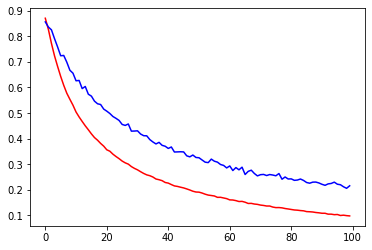

In [25]:
# After finding the best parameters, apply them to test data
np.random.seed(123)
W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim[embedding_dim_index],
                    hidden_dim=[], num_classes=3)

W, loss_tr, dev_loss = SGD(train_indices, train_label,
                            W,
                            X_dev=development_indices, 
                            Y_dev=development_label,
                            lr=lr[lr_index], 
                            dropout=dropout[dropout_index],
                            freeze_emb=False,
                            tolerance=0.0000001,
                            epochs=100)

# plot the graph of training loss and validation loss
plt.plot(loss_tr, 'r')
plt.plot(dev_loss, 'b')

# get the accuracy, precision, etc. of the best model
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_indices,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8464961067853171
Precision: 0.8494941076940005
Recall: 0.8464882943143812
F1-Score: 0.8463549984338092

The model is neither overfitting nor underfitting. The train loss doesn't bounce back means this model doesn't overfit and the loss is reducing as the epochs getting bigger means this model doesn't underfit. Though the difference between train and validation loss is larger than the other two models, it is still acceptable. Also, the accuracy is about 85%, which is great.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [26]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [27]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocab_to_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [28]:
np.random.seed(123)
w_pretrained = network_weights(vocab_size=len(vocab),embedding_dim=w_glove.shape[1],hidden_dim=[], num_classes=3)
w_pretrained[0] = w_glove

for i in range(len(w_pretrained)):
    print('Shape w_pretrained'+str(i), w_pretrained[i].shape)

Shape w_pretrained0 (81707, 300)
Shape w_pretrained1 (300, 3)


### Discuss how did you choose model hyperparameters ? 

max accuracy: 0.9395973154362416
lr:  0.01
dropout:  0.1
epochs:  100
+--------------+--------------------+--------------------+--------------------+
|  lr = 0.01   |   dropout = 0.1    |   dropout = 0.2    |   dropout = 0.3    |
+--------------+--------------------+--------------------+--------------------+
| epochs = 50  | 0.9261744966442953 | 0.912751677852349  | 0.8926174496644296 |
| epochs = 100 | 0.9395973154362416 | 0.8859060402684564 | 0.8657718120805369 |
| epochs = 200 | 0.8859060402684564 | 0.8859060402684564 | 0.8523489932885906 |
+--------------+--------------------+--------------------+--------------------+
+--------------+--------------------+--------------------+--------------------+
|  lr = 0.001  |   dropout = 0.1    |   dropout = 0.2    |   dropout = 0.3    |
+--------------+--------------------+--------------------+--------------------+
| epochs = 50  | 0.8590604026845637 | 0.8523489932885906 | 0.8456375838926175 |
| epochs = 100 | 0.8523489932885906 | 0.8523489932

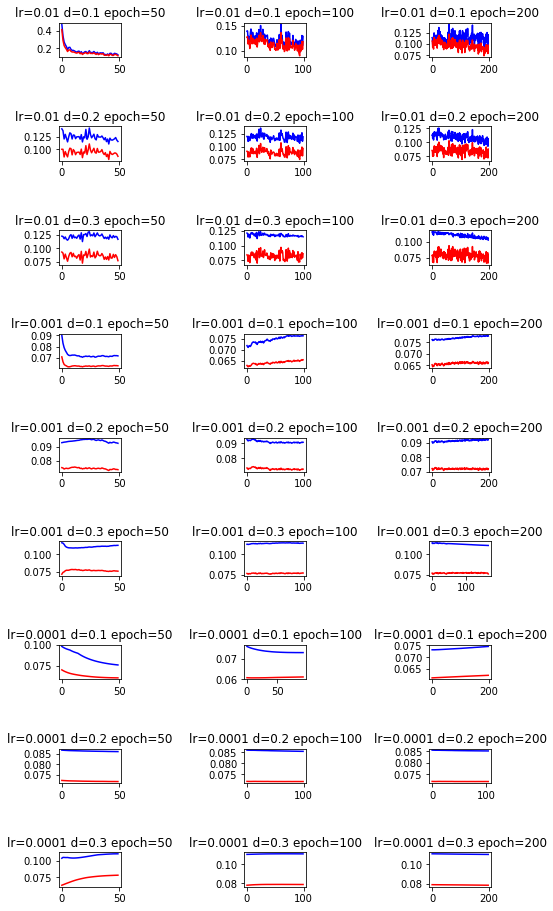

In [29]:
tune2_start = time.time()
np.random.seed(123)
lr = [0.01, 0.001, 0.0001]
dropout = [0.1, 0.2, 0.3]
epochs = [50, 100, 200]
# create the table showing performance of each model. Here I use accuracy as the performance.
table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
acc_history = []

z=1
w_pretrained = network_weights(vocab_size=len(vocab),embedding_dim=w_glove.shape[1],
        hidden_dim=[], num_classes=3)
w_pretrained[0] = w_glove
for i in range(len(lr)):
    for j in range(len(dropout)):
        for k in range(len(epochs)):
            # train model with different parameters
            W, loss_tr, dev_loss = SGD(train_indices, train_label,
                                        w_pretrained,
                                        X_dev=development_indices, 
                                        Y_dev=development_label,
                                        lr=lr[i], 
                                        dropout=dropout[j],
                                        freeze_emb=True,
                                        tolerance=0.0000001,
                                        epochs=epochs[k], print_progress=False)
            # choose the best model by selecting the highest accuracy on the dev set
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(development_indices,development_label)]
            acc_history.append(accuracy_score(development_label,preds_te))
            plt.subplot(9,3,z)
            plt.plot(dev_loss, 'b')
            plt.plot(loss_tr, 'r')
            plt.title('lr={}'.format(lr[i])+' d={}'.format(dropout[j])+' epoch={}'.format(epochs[k]))
            
            z+=1
            
    if i == 0:
        table_lr0.add_row(["epochs = {}".format(epochs[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr0.add_row(["epochs = {}".format(epochs[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr0.add_row(["epochs = {}".format(epochs[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])
    if i == 1:
        table_lr1.add_row(["epochs = {}".format(epochs[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr1.add_row(["epochs = {}".format(epochs[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr1.add_row(["epochs = {}".format(epochs[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])
    if i == 2:
        table_lr2.add_row(["epochs = {}".format(epochs[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr2.add_row(["epochs = {}".format(epochs[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr2.add_row(["epochs = {}".format(epochs[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])

result = max(acc_history)
print('max accuracy:', result)
index_of_result = acc_history.index(result)
lr_index = (index_of_result)//9
dropout_index = (index_of_result%9)//3
epochs_index = (index_of_result%3)
print('lr: ', lr[lr_index])
print('dropout: ', dropout[dropout_index])
print('epochs: ', epochs[epochs_index])
print(table_lr0)
print(table_lr1)
print(table_lr2)
plt.subplots_adjust(left=6,
                    bottom=2, 
                    right=7, 
                    top=5, 
                    wspace=2, 
                    hspace=2)
plt.show()
tune2_end = time.time()

train loss:  [0.3044191720673576, 0.2063832434225491, 0.1494731411713583, 0.12571129527633562, 0.11440778697198835, 0.08759247459108083, 0.08465208204599264, 0.08775412713047855, 0.06983038876458995, 0.061135568300087845, 0.05858975965628737, 0.051322938296389814, 0.04578828463376169, 0.04272439072014476, 0.037441222203100324, 0.03881118476690224, 0.03271572098123273, 0.03304608836586431, 0.024604406125759974, 0.02764998527720074, 0.02327988285492521, 0.022798984706935557, 0.022150161452480298, 0.019464433696418103, 0.019769547146076198, 0.019201166001268102, 0.01722725821920509, 0.016646556944271446, 0.015234100686324496, 0.016322964727785928, 0.013278985379540765, 0.013797956665198854, 0.013671529985590548, 0.01282049062114236, 0.012521061921076096, 0.012186476732550432, 0.010603616188320347, 0.011916597126266616, 0.01137137677497095, 0.008767584442564239, 0.009058142720309867, 0.00824880493149863, 0.01023571455551263, 0.008100544580811109, 0.00919930912833965, 0.009290542653233529, 

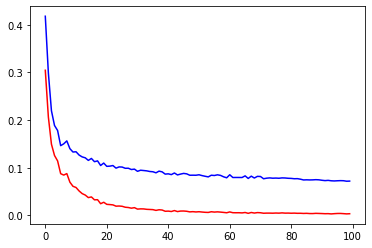

In [30]:
# After finding the best parameters, apply them to test data
np.random.seed(123)
w_pretrained = network_weights(vocab_size=len(vocab),embedding_dim=w_glove.shape[1],
                    hidden_dim=[], num_classes=3)
w_pretrained[0] = w_glove

W, loss_tr, dev_loss = SGD(train_indices, train_label,
                            w_pretrained,
                            X_dev=development_indices, 
                            Y_dev=development_label,
                            lr=lr[lr_index], 
                            dropout=dropout[dropout_index],
                            freeze_emb=True,
                            tolerance=0.0000001,
                            epochs=epochs[epochs_index])

# plot the graph of training loss and validation loss
plt.plot(loss_tr, 'r')
plt.plot(dev_loss, 'b')

# get the accuracy, precision, etc. of the best model
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_indices,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

This model is neither overfitting nor underfitting because of the same reason in the first model. Also, the validation loss (the blue line) is lower than 0.1, which means it performs real good on validation set. Moreover, the accuracy of the model is about 87.2%. To conclude, this is an accurate model without overfitting and underfitting.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [31]:
np.random.seed(123)
w_extended = network_weights(vocab_size=len(vocab),embedding_dim=w_glove.shape[1],hidden_dim=[200], num_classes=3)
w_extended[0] = w_glove

for i in range(len(w_extended)):
    print('Shape w_extended'+str(i), w_extended[i].shape)

Shape w_extended0 (81707, 300)
Shape w_extended1 (300, 200)
Shape w_extended2 (200, 3)


### Discuss how did you choose model hyperparameters ? 

<ipython-input-15-d3c86f3461d1>:2: RuntimeWarning: overflow encountered in exp
  sig = np.exp(z)/sum(np.exp(z))
<ipython-input-15-d3c86f3461d1>:2: RuntimeWarning: invalid value encountered in true_divide
  sig = np.exp(z)/sum(np.exp(z))
<ipython-input-15-d3c86f3461d1>:2: RuntimeWarning: overflow encountered in exp
  sig = np.exp(z)/sum(np.exp(z))
<ipython-input-15-d3c86f3461d1>:2: RuntimeWarning: invalid value encountered in true_divide
  sig = np.exp(z)/sum(np.exp(z))
<ipython-input-15-d3c86f3461d1>:2: RuntimeWarning: overflow encountered in exp
  sig = np.exp(z)/sum(np.exp(z))
<ipython-input-15-d3c86f3461d1>:2: RuntimeWarning: invalid value encountered in true_divide
  sig = np.exp(z)/sum(np.exp(z))


max accuracy: 0.912751677852349
lr:  0.0001
dropout:  0.2
hidden_dim:  [50]
+-------------------------+--------------------+--------------------+--------------------+
|        lr = 0.01        |   dropout = 0.1    |   dropout = 0.2    |   dropout = 0.3    |
+-------------------------+--------------------+--------------------+--------------------+
|    hidden_dim = [200]   | 0.8657718120805369 |  0.87248322147651  |  0.87248322147651  |
| hidden_dim = [200, 100] | 0.3288590604026846 | 0.3288590604026846 | 0.3288590604026846 |
|    hidden_dim = [50]    | 0.8791946308724832 | 0.8859060402684564 | 0.8993288590604027 |
+-------------------------+--------------------+--------------------+--------------------+
+-------------------------+--------------------+--------------------+--------------------+
|        lr = 0.001       |   dropout = 0.1    |   dropout = 0.2    |   dropout = 0.3    |
+-------------------------+--------------------+--------------------+--------------------+
|    hidden_di

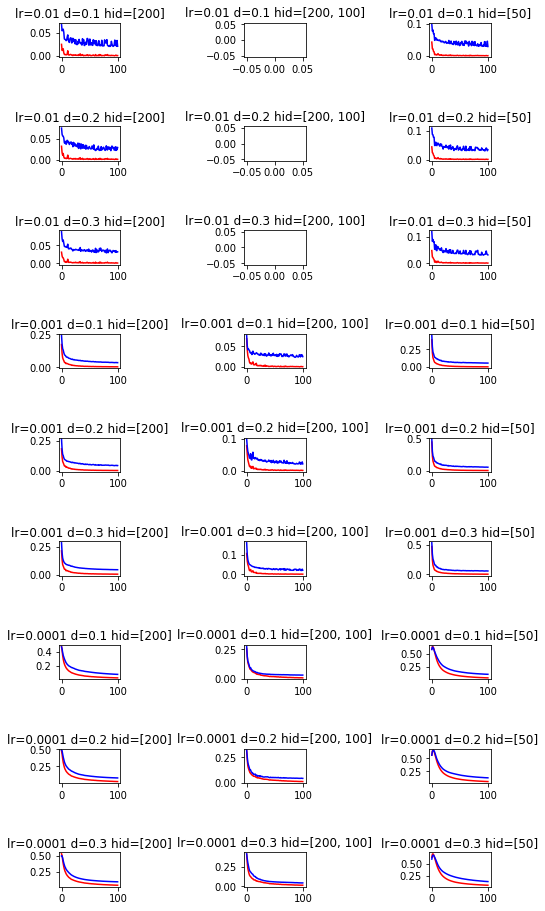

In [32]:
tune3_start = time.time()
np.random.seed(123)
lr = [0.01, 0.001, 0.0001]
dropout = [0.1, 0.2, 0.3]
hidden_dim = [[200], [200,100], [50]]
# create the table showing performance of each model. Here I use accuracy as the performance.
table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "dropout = {}".format(dropout[0]), "dropout = {}".format(dropout[1])
            , "dropout = {}".format(dropout[2])])
acc_history = []

z=1

for i in range(len(lr)):
    for j in range(len(dropout)):
        for k in range(len(hidden_dim)):
            # train model with different parameters
            w_extended = network_weights(vocab_size=len(vocab),embedding_dim=w_glove.shape[1],
            hidden_dim=hidden_dim[k], num_classes=3)
            w_extended[0] = w_glove
            
            W, loss_tr, dev_loss = SGD(train_indices, train_label,
                                        w_extended,
                                        X_dev=development_indices, 
                                        Y_dev=development_label,
                                        lr=lr[i], 
                                        dropout=dropout[j],
                                        freeze_emb=True,
                                        tolerance=0.0000001,
                                        epochs=100, print_progress=False)
            # choose the best model by selecting the highest accuracy on the dev set
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(development_indices,development_label)]
            acc_history.append(accuracy_score(development_label,preds_te))
            plt.subplot(9,3,z)
            plt.plot(loss_tr, 'r')
            plt.plot(dev_loss, 'b')
            plt.title('lr={}'.format(lr[i])+' d={}'.format(dropout[j])+' hid={}'.format(hidden_dim[k]))
            
            z+=1
            
    if i == 0:
        table_lr0.add_row(["hidden_dim = {}".format(hidden_dim[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr0.add_row(["hidden_dim = {}".format(hidden_dim[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr0.add_row(["hidden_dim = {}".format(hidden_dim[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])
    if i == 1:
        table_lr1.add_row(["hidden_dim = {}".format(hidden_dim[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr1.add_row(["hidden_dim = {}".format(hidden_dim[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr1.add_row(["hidden_dim = {}".format(hidden_dim[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])
    if i == 2:
        table_lr2.add_row(["hidden_dim = {}".format(hidden_dim[0]), acc_history[i*9+0], acc_history[i*9+3], acc_history[i*9+6]])
        table_lr2.add_row(["hidden_dim = {}".format(hidden_dim[1]), acc_history[i*9+1], acc_history[i*9+4], acc_history[i*9+7]])
        table_lr2.add_row(["hidden_dim = {}".format(hidden_dim[2]), acc_history[i*9+2], acc_history[i*9+5], acc_history[i*9+8]])

result = max(acc_history)
print('max accuracy:', result)
index_of_result = acc_history.index(result)
lr_index = (index_of_result)//9
dropout_index = (index_of_result%9)//3
hidden_dim_index = (index_of_result%3)
print('lr: ', lr[lr_index])
print('dropout: ', dropout[dropout_index])
print('hidden_dim: ', hidden_dim[hidden_dim_index])
print(table_lr0)
print(table_lr1)
print(table_lr2)
plt.subplots_adjust(left=4,
                    bottom=2, 
                    right=5, 
                    top=5, 
                    wspace=2, 
                    hspace=2)
plt.show()
tune3_end = time.time()

train loss:  [0.5699937164266979, 0.6456343025323632, 0.6560533192215144, 0.640076211547276, 0.6057155301081583, 0.5629547306546737, 0.5174487968702685, 0.4764059767260704, 0.43585942102734787, 0.4001714755872834, 0.3684481863451038, 0.3407736209998083, 0.31696785155119767, 0.29467840867179496, 0.2761034463264166, 0.25955446989897996, 0.2437672768136047, 0.23066328228138355, 0.21830776984855763, 0.20762549261918944, 0.19782680479248171, 0.18949193874455805, 0.18184689914265453, 0.17438656338045944, 0.16838941966939494, 0.1616732326999553, 0.15590130159935914, 0.1501488656844716, 0.1450214221820796, 0.140599992204753, 0.1357877527583617, 0.13182715396585967, 0.1282249053110454, 0.12447451207623635, 0.12118831105473504, 0.11801149882042693, 0.11499261589118698, 0.11176165339849096, 0.10914498706851743, 0.106267318687654, 0.1034710031919812, 0.10078691862063384, 0.09891421105447058, 0.09660945080873456, 0.0945958049110219, 0.09283049880100755, 0.09087182797673672, 0.08908462213827278, 0.0

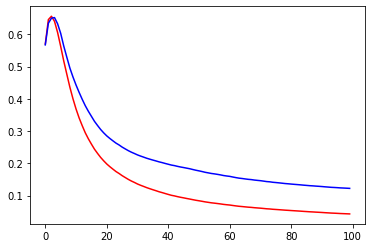

In [33]:
# After finding the best parameters, apply them to test data
np.random.seed(123)
w_extended = network_weights(vocab_size=len(vocab),embedding_dim=w_glove.shape[1],
                    hidden_dim=hidden_dim[hidden_dim_index], num_classes=3)
w_extended[0] = w_glove
W, loss_tr, dev_loss = SGD(train_indices, train_label,
                            w_extended,
                            X_dev=development_indices, 
                            Y_dev=development_label,
                            lr=lr[lr_index], 
                            dropout=dropout[dropout_index],
                            freeze_emb=True,
                            tolerance=0.0000001,
                            epochs=100)

# plot the graph of training loss and validation loss
plt.plot(loss_tr, 'r')
plt.plot(dev_loss, 'b')

# get the accuracy, precision, etc. of the best model
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_indices,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))
end_time = time.time()
time_used = (end_time-start_time-(tune1_end-tune1_start)-(tune2_end-tune2_start)-(tune3_end-tune3_start))/60
print('It takes ', time_used, 'minutes to run the code')

This model is neither overfitting nor underfitting. The only problem is that the validation loss curve shocks. When using smaller dropout rate, such as 0.1, the validation loss will become smoother. However, that model works worse than this model. It is kind of tradeoff, and I choose this model to be the best model.

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  0.8527593830614076 |  0.8498253437383871 |0.8494664856906962   |  0.8498331479421579 |
| Average Embedding (Pre-trained)  |  0.8733180409890507 | 0.8720549981419546  | 0.8721743420278848  |  0.8720800889877642 |
| Average Embedding (Pre-trained) + X hidden layers    | 0.8961146484636417  | 0.8964957264957265  | 0.8959742351046698  | 0.896551724137931  |


Please discuss why your best performing model is better than the rest.

The best model is the model with hidden layer and the second best model is the model with pre-trained embedding layer.
Pre-trained model is better than the first model is because pre-trained model use a trained embedding layer and this layer doesn't change while training the model. A trained embedding layer is reasonably better than the model with no pre-trained embedding layer.
The model with hidden layer works better than the model without hidden layer. This is because the relu function in the hidden layer makes the classification formula generated by the model closer to the true classification formula. Thus, the third model works better than the second one and the second one works better than the first one.